In [1]:
import torch
import torchvision
import numpy as np
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [2]:
dataset=MNIST(root='data/', download=True, transform=ToTensor())

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [3]:
def split_indices(n, val):
    n_val=int(n*val)
    indx=np.random.permutation(n)
    return indx[:n_val], indx[n_val:]

In [4]:
val_indices, train_indices=split_indices(len(dataset), 0.2)

In [5]:
batch_size=128
train_sampler=SubsetRandomSampler(train_indices)
train_dl=DataLoader(dataset, batch_size, sampler=train_sampler)
val_sampler=SubsetRandomSampler(val_indices)
val_dl=DataLoader(dataset, batch_size, sampler=val_sampler)

In [6]:
import torch.nn.functional as F
import torch.nn as nn

In [7]:
class MNIST_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1=nn.Linear(input_size, hidden_size)
        self.linear2=nn.Linear(hidden_size, output_size)
    
    def forward(self, xb):
        xb=xb.view(xb.size(0),-1)
        out=self.linear1(xb)
        out=F.relu(out)
        out=self.linear2(out)
        return out

In [8]:
input_size=784
num_class=10

model=MNIST_Model(input_size=input_size, hidden_size=32, output_size=num_class)

In [9]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [10]:
for images, labels in train_dl:
    outputs=model(images)
    loss=F.cross_entropy(outputs, labels)
    print('Loss : ', loss.item())
    break

Loss :  2.3000965118408203


In [11]:
torch.cuda.is_available()

True

In [12]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [13]:
device=get_default_device()
device

device(type='cuda')

In [14]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [15]:
for images, labels in train_dl:
    images=to_device(images, device)
    print(images.device)
    break

cuda:0


In [16]:
class Device_DataLoader():
    def __init__(self, dl, device):
        self.dl=dl
        self.device=device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [17]:
train_dl=Device_DataLoader(train_dl, device)
val_dl=Device_DataLoader(val_dl, device)

In [18]:
for xb,yb in val_dl:
    print(xb.device)
    break

cuda:0


In [19]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    preds=model(xb)
    loss=loss_func(preds, yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    metric_result=None
    if metric is not None:
        metric_result=metric(preds, yb)
    return loss.item(), len(xb), metric_result

In [20]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        results=[loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in val_dl]
        losses, nums, metrics=zip(*results)
        total=np.sum(nums)
        avg_loss=np.sum(np.multiply(losses,nums))/total
        avg_metric=None
        if metric is not None:
            avg_metric=np.sum(np.multiply(metrics, nums))/total
        
    return avg_loss, total, avg_metric

In [21]:
def fit(epochs, lr, model, loss_fn, train_dl, valid_dl, metric=None, opt_fn=None):
    losses, metrics=[],[]
    if opt_fn is None: opt_fn=torch.optim.SGD
    opt=torch.optim.SGD(model.parameters(), lr=lr)
    for epoch in range(epochs):
        for xb,yb in train_dl:
            loss,_,_=loss_batch(model, loss_fn, xb, yb, opt)
        result=evaluate(model, loss_fn, val_dl, metric)
        val_loss, total, val_metric=result
        losses.append(val_loss)
        metrics.append(val_metric)
        if metric is None:
            print('Epoch [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, epochs, val_loss))
        else:
            print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'
                  .format(epoch+1, epochs, val_loss, 
                          metric.__name__, val_metric))
            
    return losses, metrics

In [22]:
def accuracy(outputs, labels):
    _,preds=torch.max(outputs, dim=1)
    return torch.sum(preds==labels).item()/len(preds)

In [23]:
model=MNIST_Model(input_size=input_size, hidden_size=32, output_size=num_class)
to_device(model, device)
val_loss, total, val_acc = evaluate(model, F.cross_entropy, 
                                    val_dl, metric=accuracy)

In [24]:
losses1, metrics1=fit(5, 0.5, model, F.cross_entropy, train_dl, val_dl, accuracy)

Epoch [1/5], Loss: 0.2370, accuracy: 0.9322
Epoch [2/5], Loss: 0.1927, accuracy: 0.9434
Epoch [3/5], Loss: 0.1557, accuracy: 0.9531
Epoch [4/5], Loss: 0.1628, accuracy: 0.9529
Epoch [5/5], Loss: 0.1648, accuracy: 0.9513


In [25]:
losses2, metrics2=fit(5, 0.1, model, F.cross_entropy, train_dl, val_dl, accuracy)

Epoch [1/5], Loss: 0.1281, accuracy: 0.9632
Epoch [2/5], Loss: 0.1256, accuracy: 0.9621
Epoch [3/5], Loss: 0.1261, accuracy: 0.9615
Epoch [4/5], Loss: 0.1260, accuracy: 0.9616
Epoch [5/5], Loss: 0.1273, accuracy: 0.9620


In [26]:
losses3, metrics3=fit(5, 0.01, model, F.cross_entropy, train_dl, val_dl, accuracy)

Epoch [1/5], Loss: 0.1228, accuracy: 0.9627
Epoch [2/5], Loss: 0.1226, accuracy: 0.9626
Epoch [3/5], Loss: 0.1221, accuracy: 0.9624
Epoch [4/5], Loss: 0.1219, accuracy: 0.9631
Epoch [5/5], Loss: 0.1219, accuracy: 0.9627


In [29]:
losses2, metrics2=fit(10, 0.001, model, F.cross_entropy, train_dl, val_dl, accuracy)

Epoch [1/5], Loss: 0.1219, accuracy: 0.9631
Epoch [2/5], Loss: 0.1219, accuracy: 0.9632
Epoch [3/5], Loss: 0.1219, accuracy: 0.9632
Epoch [4/5], Loss: 0.1219, accuracy: 0.9631
Epoch [5/5], Loss: 0.1219, accuracy: 0.9632


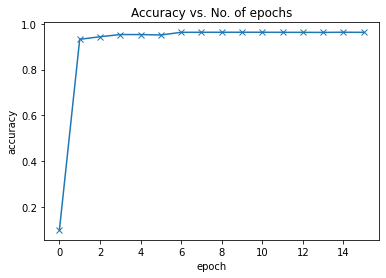

In [28]:
import matplotlib.pyplot as plt
accuracies = [val_acc] + metrics1 + metrics2+metrics3
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [32]:
test_dataset=MNIST(root='data', train=False, transform=ToTensor())
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()
test_loader = DataLoader(test_dataset, batch_size=200)
test_loss, total, test_acc = evaluate(model, F.cross_entropy, test_loader, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(test_loss, test_acc))

Loss: 0.1219, Accuracy: 0.9632
